# Simple implementation of Simple Traffic Light Segmentation Neural Net



# Datasets

I will create a dataset of generic shapes and train the neural net to segment the images first by colour and then by shapes.


## Colour data set

In [1]:
import numpy as np
import pandas as pd
import re


# Show images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

import random

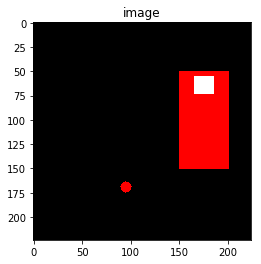

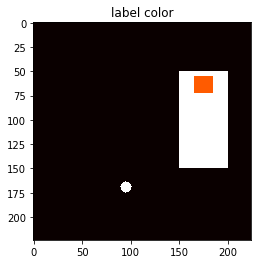

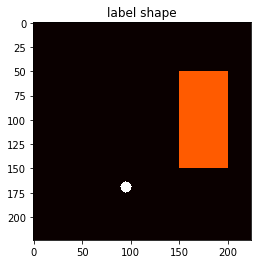

Image size (224, 224, 3)


In [2]:
class TrainingImage:
    """ 
    This class handles the creation of training
    images and the associated label image
    """
    #Colors classes    
    BLACK_CLASS = 0
    WHITE_CLASS = 1
    RED_CLASS = 2
    LIME_CLASS = 3
    BLUE_CLASS = 4
    YELLOW_CLASS = 5
    CYAN_CLASS = 6
    MAGENTA_CLASS = 7
    SILVER_CLASS = 8
    GRAY_CLASS = 9
    MAROON_CLASS = 10
    OLIVE_CLASS = 11
    GREEN_CLASS = 12
    PURPLE_CLASS = 13
    TEAL_CLASS = 14
    NAVY_CLASS = 15
    
    COLOR = {
        BLACK_CLASS : (0,0,0),
        WHITE_CLASS : (255,255,255),
        RED_CLASS : (255,0,0),
#         LIME_CLASS : (0,255,0),
#         BLUE_CLASS : (0,0,255),
#         YELLOW_CLASS : (255,255,0),
#         CYAN_CLASS : (0,255,255),
#         MAGENTA_CLASS : (255,0,255),
#         SILVER_CLASS : (192,192,192),
#         GRAY_CLASS : (128,128,128),
#         MAROON_CLASS : (128,0,0),
#         OLIVE_CLASS : (128,128,0),
#         GREEN_CLASS : (0,128,0),
#         PURPLE_CLASS : (128,0,128),
#         TEAL_CLASS : (0,128,128),
#         NAVY_CLASS : (0,0,128),
    }
    
    NO_SHAPE = 0
    RECTANGLE_CLASS = 1
    CIRCLE_CLASS = 2
    
    MIN_SIZE = 10
    MAX_SIZE = 20
    
    
    def __init__(self, size=(224,224, 3), backgd_color_class=BLACK_CLASS):
        self.size = size
        self.createImageBackground(backgd_color_class)
        
    def clear(self):
        self.image = np.zeros(self.size, dtype=np.uint8)
        self.label = np.zeros(self.size[0:2] + (len(TrainingImage.COLOR.keys()), ) , dtype=np.uint8)
        self.label_shape = np.zeros(self.size[0:2] + (self.CIRCLE_CLASS+1, ) , dtype=np.uint8)
        
    def createImageBackground(self, backgd_color_class):
        self.backgd_color_class = backgd_color_class
        self.clear()
        for channel in range(0, 3):
            self.image[:,:,channel] = TrainingImage.COLOR[self.backgd_color_class][channel]
        self.label[:,:, self.backgd_color_class] = 1
    
    def createRectangle(self, pt1, pt2, color_class=WHITE_CLASS):
        cv2.rectangle(self.image, 
                      pt1[::-1], pt2[::-1], TrainingImage.COLOR[color_class], thickness=cv2.FILLED)
        self.label[pt1[0]:pt2[0],pt1[1]:pt2[1], :] =  0 # Clear exisiting labels in target color position
        self.label[pt1[0]:pt2[0],pt1[1]:pt2[1], color_class] =  1 # Set exisiting labels in target color class position
        
        
        self.label_shape[pt1[0]:pt2[0],pt1[1]:pt2[1], :] =  0 # Clear exisiting labels in target position
        self.label_shape[pt1[0]:pt2[0],pt1[1]:pt2[1], self.RECTANGLE_CLASS] =  1 # Set exisiting labels in target shape class position
        
    def createCircle(self, center, radius, color_class=WHITE_CLASS):
        cv2.circle(self.image, center[::-1], radius, TrainingImage.COLOR[color_class], thickness=cv2.FILLED) 
        # Clear exisiting labels in target position
        
        for chan in range(self.label_shape.shape[2]):
            label_chan = np.array(self.label_shape[:,:,chan])
            self.label_shape[:,:,chan] = cv2.circle(label_chan, center[::-1], radius,
                                                    0, thickness=cv2.FILLED)
        
        for chan in range(self.label.shape[2]):
            label_chan = np.array(self.label[:,:,chan])
            self.label[:,:,chan] = cv2.circle(label_chan, center[::-1], radius,
                                                    0, thickness=cv2.FILLED)
            
        # Set label pixel for the shape class channel
        self.label_shape[:,:, self.CIRCLE_CLASS] = cv2.circle(np.array(self.label[:,:, self.CIRCLE_CLASS]), 
                                                       center[::-1], radius, 1, thickness=cv2.FILLED)
        # Set label pixel for the color class channel
        self.label[:,:,color_class] = cv2.circle(np.array(self.label[:,:,color_class]), 
                                                       center[::-1], radius, 1, thickness=cv2.FILLED)
    
    def addRandRectangle(self, color_class=WHITE_CLASS):
        image_size = self.image.shape
        pt1 = (random.randint(0, image_size[0]-self.MAX_SIZE), 
               random.randint(0, image_size[1] - self.MAX_SIZE))
        pt2 = (random.randint(pt1[0]+self.MIN_SIZE, min(image_size[0]-1, pt1[0]+self.MAX_SIZE) ),
               random.randint(  pt1[1]+self.MIN_SIZE, min(image_size[1]-1, pt1[1]+self.MAX_SIZE) ))
        self.createRectangle( pt1, pt2, color_class=color_class)
        
    def addRandCircle(self, color_class=WHITE_CLASS):
        image_size = self.image.shape
        center = (random.randint(self.MIN_SIZE, image_size[0]-self.MAX_SIZE), 
                  random.randint(self.MIN_SIZE, image_size[1]-self.MAX_SIZE))
        radius = random.randint(self.MIN_SIZE//2, self.MAX_SIZE//2)
        self.createCircle( center, radius, color_class=color_class)


image_size = (224,224, 3)
trainim = TrainingImage(size=image_size , backgd_color_class=TrainingImage.BLACK_CLASS)
trainim.createRectangle( (50,150) , (150,200), color_class=TrainingImage.RED_CLASS)
trainim.addRandRectangle(TrainingImage.WHITE_CLASS)
trainim.addRandCircle(TrainingImage.RED_CLASS)
#trainim.createCircle( (150, 20), 100 )

# Plot background 
plt.imshow(trainim.image)
plt.title('image')
plt.show()

# Plot background 
plt.imshow(trainim.label.argmax(axis=2), cmap='hot')
plt.title('label color')
plt.show()

plt.imshow(trainim.label_shape.argmax(axis=2), cmap='hot')
plt.title('label shape')
plt.show()




print('Image size {}'.format(trainim.image.shape))

In [3]:
# Generate color training dataset
from functools import reduce


NUM_TRAIN = 512
num_classes = len(TrainingImage.COLOR.keys())
image_size = (224,224, 3)
label_size = (224,224, num_classes)
size_in_memory = 1
image_mem = reduce(lambda a,b : a*b ,image_size, 1)
label_mem = reduce(lambda a,b : a*b ,label_size, 1)
total_train_mem = NUM_TRAIN * (image_mem + label_mem)
print('Total size of the use of memory : {}MB'.format(total_train_mem/(1024*1024)))



def generateRectangleData(X, y, num_samples):
    trainim = TrainingImage(size=image_size)
    for i in range(num_samples):
        trainim.createImageBackground(TrainingImage.BLACK_CLASS)
        for j in range(20):
            trainim.addRandRectangle(color_class=random.randint(1, num_classes-1))

        X[i] = trainim.image
        y[i] = trainim.label
    return X, y

X_TRAIN_SIZE = (NUM_TRAIN,) + image_size
Y_TRAIN_SIZE = (NUM_TRAIN,) + image_size[0:2] + (num_classes, )
X_train = np.zeros(X_TRAIN_SIZE, dtype=np.uint8)
y_train = np.zeros(Y_TRAIN_SIZE, dtype=np.uint8)
X_train, y_train = generateRectangleData(X_train, y_train, NUM_TRAIN)

NUM_VAL = 64
X_VAL_SIZE = (NUM_VAL,) + image_size
Y_VAL_SIZE = (NUM_VAL,) + image_size[0:2] + (num_classes, )
X_val = np.zeros(X_VAL_SIZE, dtype=np.uint8)
y_val = np.zeros(Y_VAL_SIZE, dtype=np.uint8)
X_val, y_val = generateRectangleData(X_val, y_val, NUM_VAL)

# Training statistics
count_pixel_classes = y_train.astype(np.uint64).sum(axis=0).sum(axis=0).sum(axis=0)
count_all_pixel_images = np.prod(y_train.shape)
print('sum_classes',count_pixel_classes,'count_all_pixel_images',count_all_pixel_images)

classes_freq = count_pixel_classes/count_all_pixel_images
print('classes_freq',classes_freq)

# Median balancing for segmentation https://arxiv.org/pdf/1511.00561.pdf
median_balancing_weights = np.median(classes_freq)/classes_freq
print('median balancing', median_balancing_weights)

Total size of the use of memory : 147.0MB
sum_classes [23489703  1072918  1127491] count_all_pixel_images 77070336
classes_freq [ 0.30478267  0.01392128  0.01462938]
median balancing [ 0.04799937  1.05086409  1.        ]


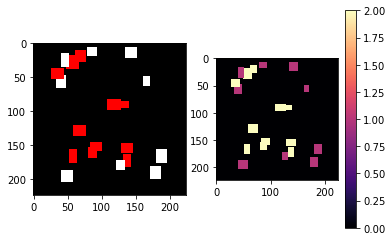

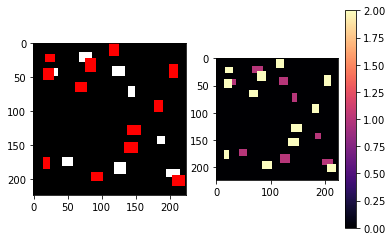

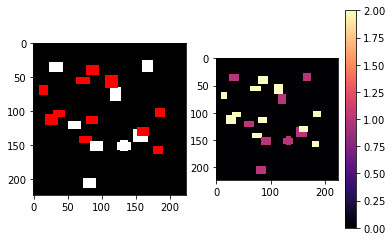

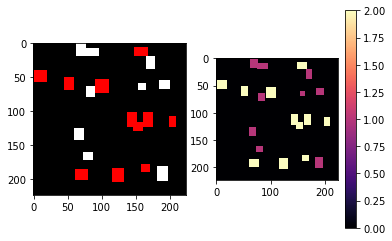

In [4]:
# Plot color evaluation dataset

for idx in range(3,7):

    fig = plt.figure(1)
    ax = fig.add_subplot(1,2,1)
    imsh = ax.imshow( X_train[idx], cmap='magma')

    ax = fig.add_subplot(1,2,2)
    imsh = ax.imshow( y_train[idx,:,:,:].argmax(axis=2), cmap='magma')
    plt.colorbar(imsh)
    plt.show()


In [5]:
w=median_balancing_weights
print(w)
#w = np.reshape(w,(1,1,3))
#print('reshaped',w)
print('tile')
print(np.tile(w,(1,2,1)) )

[ 0.04799937  1.05086409  1.        ]
tile
[[[ 0.04799937  1.05086409  1.        ]
  [ 0.04799937  1.05086409  1.        ]]]


# Model
The original paper uses VGG for implementing the detector.


TODO : Will try experimenting with Xception and MobileNet  
https://keras.io/applications/#usage-examples-for-image-classification-models


In [6]:

# Extract features from an arbitrary intermediate layer with VGG19

from segmodel import SegModel

# Extract pooling layers out of VGG-16
num_classes = len(TrainingImage.COLOR.keys())

segModel = SegModel(num_classes, class_weight=median_balancing_weights) 
model = segModel.getModel()


Using TensorFlow backend.


Pre-trained model loaded.
weights.shape (224, 224, 3)
sigmoided_matrix_in.shape (?, 224, 224, 3)
sigmoided_matrix.shape (?, 224, 224, 3)
sum_sig.shape (?, 224, 224)
weights.shape (224, 224, 3)
sigmoided_matrix_in.shape (?, 224, 224, 3)
sigmoided_matrix.shape (?, 224, 224, 3)
sum_sig.shape (?, 224, 224)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
___

In [7]:
## Loss function definition

In [8]:
from keras import backend as K
import tensorflow as tf

# https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/9d0fb65d67334dc332816bcb30d317c2de8b9137/train.py#L23

def dice_coef(y_true, y_pred):
    smooth = 1.0e1
    y_true_f = K.square(K.flatten(y_true))
    y_pred_f = K.square(K.flatten(y_pred))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jaccard_coef(y_true, y_pred):
    smooth = 1.0e1
    y_true_f = K.flatten(y_true) > 1e-5
    y_pred_f = K.flatten(y_pred) > 1e-5
    intersection = K.cast(tf.logical_and(y_true_f, y_pred_f), 'float32')
    union = K.cast(tf.logical_or(y_true_f, y_pred_f), 'float32')
    i_mean = K.mean(intersection, axis=0)
    u_mean = K.mean(union, axis=0)
    return (i_mean + smooth) / (u_mean + smooth)


def dice_coef_loss(y_true, y_pred):
    return -1.0 * dice_coef(y_true, y_pred)

def jaccard_coef_loss(y_true, y_pred):
    return -1.0 * jaccard_coef(y_true, y_pred)

In [9]:
from keras import optimizers
optimizer_selected = optimizers.Adam(lr=1e-3)


my_loss={'final_merge': dice_coef_loss, 'soft_out': 'categorical_crossentropy'}
my_loss_weights={'final_merge': 0.01, 'soft_out': 1.0}
model.compile(optimizer=optimizer_selected, loss=my_loss, loss_weights = my_loss_weights , 
              metrics={'final_merge':'categorical_accuracy', 'soft_out':'categorical_accuracy'})

    
    
history = model.fit(x=X_train, y=[y_train, y_train], batch_size=20, epochs=3, 
                    validation_split=0.0, validation_data=(X_val, [y_val, y_val]), shuffle=True)

Train on 512 samples, validate on 64 samples
Epoch 1/3
512/512 [==============================] - 19s 37ms/step - loss: 1.8073 - final_merge_loss: -0.6543 - soft_out_loss: 1.8138 - final_merge_categorical_accuracy: 0.7801 - soft_out_categorical_accuracy: 0.4440 - val_loss: 0.6476 - val_final_merge_loss: -0.7566 - val_soft_out_loss: 0.6551 - val_final_merge_categorical_accuracy: 0.9147 - val_soft_out_categorical_accuracy: 0.9606
Epoch 2/3
512/512 [==============================] - 14s 27ms/step - loss: 0.5672 - final_merge_loss: -0.7523 - soft_out_loss: 0.5747 - final_merge_categorical_accuracy: 0.9143 - soft_out_categorical_accuracy: 0.9741 - val_loss: 0.4737 - val_final_merge_loss: -0.7601 - val_soft_out_loss: 0.4813 - val_final_merge_categorical_accuracy: 0.9147 - val_soft_out_categorical_accuracy: 0.9796
Epoch 3/3
512/512 [==============================] - 14s 27ms/step - loss: 0.4446 - final_merge_loss: -0.7476 - soft_out_loss: 0.4520 - final_merge_categorical_accuracy: 0.9143 - so

Time for inference : 339.648962020874ms


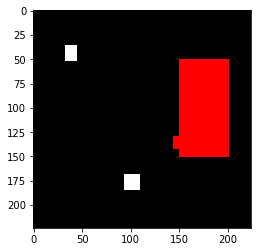

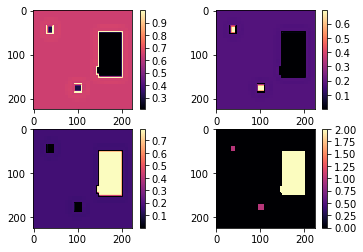

In [10]:
import time
# #Plot loss function
# plt.plot(history.epoch,history.history['loss'])
# plt.legend(('loss'))
# plt.grid('on')
# plt.show()

#img = X_train[10]

# Create a brand-new image for testing
trainim = TrainingImage(size=image_size , backgd_color_class=TrainingImage.BLACK_CLASS)
trainim.createRectangle( (50,150) , (150,200), color_class=TrainingImage.RED_CLASS)
trainim.addRandRectangle(TrainingImage.WHITE_CLASS)
trainim.addRandRectangle(TrainingImage.WHITE_CLASS)
trainim.addRandRectangle(TrainingImage.RED_CLASS)
img = trainim.image


start = time.time()
[y_out,y_softmax] = model.predict(img.reshape(1,224,224,3))
end = time.time()
print('Time for inference : {}ms'.format((end - start)*1000))


seg = y_softmax
seg = seg.reshape(224,224, num_classes)

seg_classes=seg.argmax(axis=2)

plt.imshow(img)
plt.show()

fig = plt.figure(1)
fig.clf()
ax = fig.add_subplot(2,2,1)
imsh = ax.imshow( seg[:,:,0], cmap='magma')
fig.colorbar(imsh)

ax = fig.add_subplot(2,2,2)
imsh = ax.imshow( seg[:,:,1], cmap='magma')
fig.colorbar(imsh)

ax = fig.add_subplot(2,2,3)
imsh = ax.imshow( seg[:,:,2], cmap='magma')
fig.colorbar(imsh)

ax = fig.add_subplot(2,2,4)
imsh = ax.imshow( seg_classes, cmap='magma' )
fig.colorbar(imsh)
plt.show()



In [11]:
# Generate shape training dataset
from functools import reduce


NUM_TRAIN = 1024
num_classes = 3
image_size = (224,224, 3)
label_size = (224,224, num_classes)
size_in_memory = 1
image_mem = reduce(lambda a,b : a*b ,image_size, 1)
label_mem = reduce(lambda a,b : a*b ,label_size, 1)
total_train_mem = NUM_TRAIN * (image_mem + label_mem)
print('Total size of the use of memory : {}MB'.format(total_train_mem/(1024*1024)))



def generateShapeData(X, y, num_samples):
    trainim = TrainingImage(size=image_size)
    for i in range(num_samples):
        trainim.createImageBackground(TrainingImage.BLACK_CLASS)
        for j in range(10):
            trainim.addRandRectangle(color_class=TrainingImage.RED_CLASS)
            trainim.addRandCircle(color_class=TrainingImage.RED_CLASS)
        
        X[i] = trainim.image
        y[i] = trainim.label_shape
    return X, y

X_TRAIN_SIZE = (NUM_TRAIN,) + image_size
Y_TRAIN_SIZE = (NUM_TRAIN,) + image_size[0:2] + (num_classes, )
X_train = np.zeros(X_TRAIN_SIZE, dtype=np.uint8)
y_train = np.zeros(Y_TRAIN_SIZE, dtype=np.uint8)
X_train, y_train = generateShapeData(X_train, y_train, NUM_TRAIN)

NUM_VAL = 64
X_VAL_SIZE = (NUM_VAL,) + image_size
Y_VAL_SIZE = (NUM_VAL,) + image_size[0:2] + (num_classes, )
X_val = np.zeros(X_VAL_SIZE, dtype=np.uint8)
y_val = np.zeros(Y_VAL_SIZE, dtype=np.uint8)
X_val, y_val = generateShapeData(X_val, y_val, NUM_VAL)

Total size of the use of memory : 294.0MB


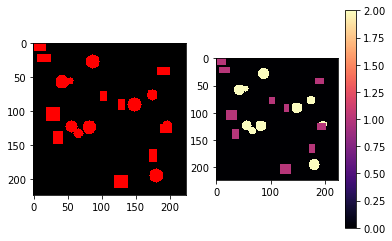

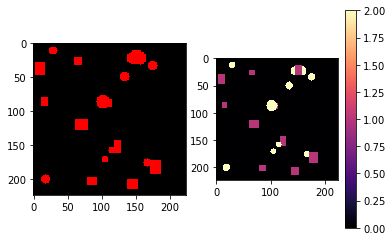

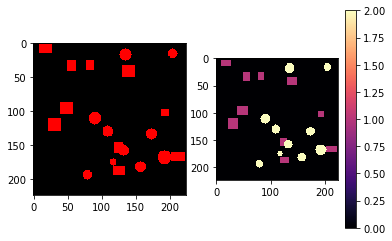

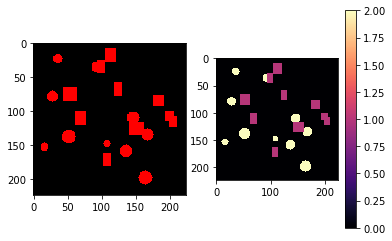

In [12]:
# Plot color evaluation dataset

for idx in range(3,7):

    fig = plt.figure(1)
    ax = fig.add_subplot(1,2,1)
    imsh = ax.imshow( X_train[idx], cmap='magma')

    ax = fig.add_subplot(1,2,2)
    imsh = ax.imshow( y_train[idx,:,:,:].argmax(axis=2), cmap='magma')
    plt.colorbar(imsh)
    plt.show()

In [13]:
from segmodel import SegModel

# Extract pooling layers out of VGG-16
num_classes = 3

segModel = SegModel(num_classes, class_weight=median_balancing_weights) 
model = segModel.getModel()

Pre-trained model loaded.
weights.shape (224, 224, 3)
sigmoided_matrix_in.shape (?, 224, 224, 3)
sigmoided_matrix.shape (?, 224, 224, 3)
sum_sig.shape (?, 224, 224)
weights.shape (224, 224, 3)
sigmoided_matrix_in.shape (?, 224, 224, 3)
sigmoided_matrix.shape (?, 224, 224, 3)
sum_sig.shape (?, 224, 224)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
___

In [14]:
from keras import backend as K
import tensorflow as tf

def jaccard_coef(y_true, y_pred):
    smooth = 1.0e1
    y_true_f = K.batch_flatten(y_true) > 1e-3
    y_pred_f = K.batch_flatten(y_pred) > 1e-3
    union        = K.cast(tf.logical_and(y_true_f, y_pred_f),'float32')
    intersection = K.cast(tf.logical_or(y_true_f, y_pred_f),'float32')
    i = K.mean(intersection)
    u = K.mean(union)
    IoU = (i + smooth) / (u + smooth)
    return IoU 


def jaccard_coef_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)

Train on 1024 samples, validate on 64 samples
Epoch 1/3
1024/1024 [==============================] - 28s 27ms/step - loss: 0.1049 - final_merge_loss: -1.1635 - soft_out_loss: 0.1165 - final_merge_categorical_accuracy: 0.4142 - soft_out_categorical_accuracy: 0.0388 - val_loss: 0.0616 - val_final_merge_loss: -1.6021 - val_soft_out_loss: 0.0776 - val_final_merge_categorical_accuracy: 0.0714 - val_soft_out_categorical_accuracy: 0.0362
Epoch 2/3
1024/1024 [==============================] - 28s 27ms/step - loss: 0.0586 - final_merge_loss: -1.6710 - soft_out_loss: 0.0754 - final_merge_categorical_accuracy: 0.0761 - soft_out_categorical_accuracy: 0.0353 - val_loss: 0.0593 - val_final_merge_loss: -1.7296 - val_soft_out_loss: 0.0766 - val_final_merge_categorical_accuracy: 0.0583 - val_soft_out_categorical_accuracy: 0.0359
Epoch 3/3
1024/1024 [==============================] - 28s 27ms/step - loss: 0.0577 - final_merge_loss: -1.7638 - soft_out_loss: 0.0753 - final_merge_categorical_accuracy: 0.10

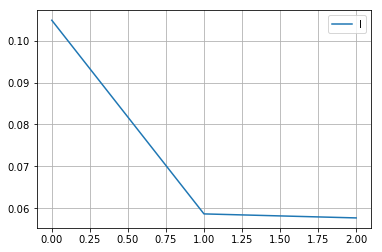

In [16]:
from keras import optimizers
optimizer_selected = optimizers.Adam(lr=1e-3)


my_loss={'final_merge': dice_coef_loss, 'soft_out': 'categorical_crossentropy'}
my_loss_weights={'final_merge': 0.01, 'soft_out': 1.0}
model.compile(optimizer=optimizer_selected, loss=my_loss, loss_weights = my_loss_weights , 
              metrics={'final_merge':'categorical_accuracy', 'soft_out':'categorical_accuracy'})

    
    
history = model.fit(x=X_train, y=[y_train, y_train], batch_size=20, epochs=3, 
                    validation_split=0.0, validation_data=(X_val, [y_val, y_val]), shuffle=True)
import time
#Plot loss function
plt.plot(history.epoch,history.history['loss'])
plt.legend(('loss'))
plt.grid('on')
plt.show()

Time for inference : 11.408805847167969ms


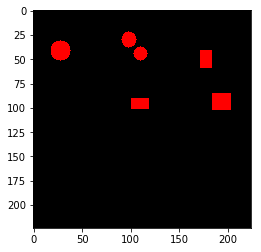

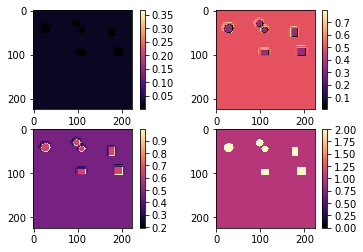

In [19]:
# Create a brand-new image for testing
trainim = TrainingImage(size=image_size , backgd_color_class=TrainingImage.BLACK_CLASS)
trainim.addRandRectangle(TrainingImage.RED_CLASS)
trainim.addRandCircle(TrainingImage.RED_CLASS)
trainim.addRandRectangle(TrainingImage.RED_CLASS)
trainim.addRandCircle(TrainingImage.RED_CLASS)
trainim.addRandRectangle(TrainingImage.RED_CLASS)
trainim.addRandCircle(TrainingImage.RED_CLASS)

img = trainim.image


start = time.time()
[y_out, y_softmax] = model.predict(img.reshape(1,224,224,3))
end = time.time()
print('Time for inference : {}ms'.format((end - start)*1000))

seg = y_softmax
seg = seg.reshape(224,224, num_classes)

seg_classes=seg.argmax(axis=2)

plt.imshow(img)
plt.show()

fig = plt.figure(1)
fig.clf()
ax = fig.add_subplot(2,2,1)
imsh = ax.imshow( seg[:,:,0], cmap='magma')
fig.colorbar(imsh)

ax = fig.add_subplot(2,2,2)
imsh = ax.imshow( seg[:,:,1], cmap='magma')
fig.colorbar(imsh)

ax = fig.add_subplot(2,2,3)
imsh = ax.imshow( seg[:,:,2], cmap='magma')
fig.colorbar(imsh)

ax = fig.add_subplot(2,2,4)
imsh = ax.imshow( seg_classes, cmap='magma' )
fig.colorbar(imsh)
plt.show()

